<a href="https://colab.research.google.com/github/iamatul1214/Tensorflow_Certification_Preparation/blob/main/05_TransferLearning_using_tensorflow_part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Here we will perform transfer learning with fine tuning of our models

In [1]:
import os
Root = "/content/drive/MyDrive/Tensorflow certifications work"
!pwd
os.chdir(Root)
!pwd

/content
/content/drive/MyDrive/Tensorflow certifications work


## We have created a helper function which includes all those small functions we worked in previous modules.

### We can import the functions form the helper.py

In [2]:
try:
  if os.path.exists(os.path.join(os.getcwd(),"Helper.py")):
    print("helper.py exists already, hence skipping downloading..")
  else:
    !wget https://raw.githubusercontent.com/iamatul1214/Tensorflow_Certification_Preparation/main/Helper.py
    print("Downloaded helper.py successfully")
except Exception as e:
  print(e)
  

helper.py exists already, hence skipping downloading..


In [3]:
from Helper import create_tensorboard_callback

## Let's get some data

### This time we will see how we can use the pretrained models frmo `tf.keras.applications` and apply them to our own problems.

In [4]:
## Getting 10% data of of 10 classes of food
from Helper import unzip_data
try:
  if os.path.exists(os.path.join(os.getcwd(),"10_food_classes_10_percent.zip")):
    print(f"data set is already unzipped and present")
  else:
    print("Downloading the data and unzipping it...")
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    ### unzipping data
    print("Unzipping the data")
    unzip_data("10_food_classes_10_percent.zip")


    
except Exception as e:
  print("data not found in the directory... Hence downloading.....")
  

data set is already unzipped and present


In [5]:
## creating train and test directories
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [6]:
## Let's walkthrough the data
from Helper import walk_through_dir
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [7]:
## This time we will not use the ImageDataGenerator, we will use even a smarter version of that.
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
## see an example of batches of our data
for images, labels in train_data_10_percent.take(1):  ## 32 is the batch size by default hence the take will take 1 batch
  print(f"Images = {images} and labels = {labels}")
  print(len(labels))

Images = [[[[ 21.         21.         19.       ]
   [ 21.85491    21.85491    19.85491  ]
   [ 22.         22.         20.       ]
   ...
   [ 25.816824   33.816822   36.816822 ]
   [ 27.061077   34.061077   40.061077 ]
   [ 27.85491    34.85491    40.85491  ]]

  [[ 20.844547   20.844547   18.844547 ]
   [ 21.         21.         19.       ]
   [ 21.564732   21.564732   19.564732 ]
   ...
   [ 26.435268   34.43527    37.43527  ]
   [ 26.16056    33.59583    38.290024 ]
   [ 26.7202     33.7202     39.7202   ]]

  [[ 20.176498   20.176498   18.176498 ]
   [ 20.948183   20.948183   18.948183 ]
   [ 21.         21.         19.       ]
   ...
   [ 26.42999    34.42999    37.42999  ]
   [ 25.071442   33.07144    36.07144  ]
   [ 27.082624   34.082623   40.082623 ]]

  ...

  [[ 17.450928   16.450928   12.450928 ]
   [ 16.777283   15.777283   11.777283 ]
   [ 16.         15.         11.       ]
   ...
   [155.01837   173.80411   177.37558  ]
   [161.78322   182.99754   185.9261   ]
   [176

## Model 0: Using transfer learning to build a keras functional API
### The Sequential API runs our layers in the model in sequential manner but functional API is more flexible and can take multiple inputs and outputs.

In [11]:
## Create base model with tf.keras.applications 
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

## Freeze the base model so that the underlying pretrained models are not retrained again
base_model.trainable = False

## create inputs to our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "Input layer")

## If we are using a model like Resnet50V2 we will need to normalize inputs, but not for effiecientNet.
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs).  ## this means passing the inputs as parameter

x = base_model(inputs)

print(f"The shape of the base model after passing the inputs is {x.shape}")

## Average pool the output of the base_model input layer

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pool_2d") (x)
print(f"The shape of the model after globalaveragepool is {x.shape}")

## create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

## combine the input and output layers
model_0 = tf.keras.Model(inputs,outputs)

## Let's check the summary of the model
print(f"moDEL SUMMARY = {model_0.summary()}")

## compiling the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

## Let's check the summary of the model
print(f"moDEL SUMMARY = {model_0.summary()}")

## fitting the model
from Helper import create_tensorboard_callback
history_0 = model_0.fit(train_data_10_percent,epochs = 3,steps_per_epoch=len(train_data_10_percent),validation_data=test_data,
                        validation_steps = int(0.25 * len(test_data)),callbacks = [create_tensorboard_callback(dir_name = "Transfer_learning",
                                                                                                               experiment_name = "feature_extraction-10_percent")])


## validation_steps = int(0.25 * len(test_data)) will reduce the validation steps to 1/4 and hence reduce training time

16719872/16705208 [==============================] - 0s 0us/step
The shape of the base model after passing the inputs is (None, 7, 7, 1280)
The shape of the model after globalaveragepool is (None, 1280)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pool_2d (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-tra

In [12]:
## Now let's evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 637s 8s/step - loss: 0.7638 - accuracy: 0.8096


[0.7637559771537781, 0.8095999956130981]

In [13]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pool_2d (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

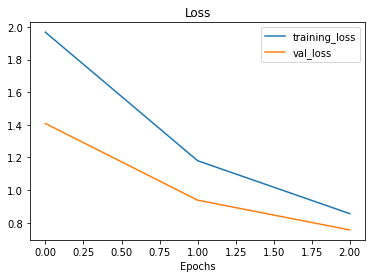

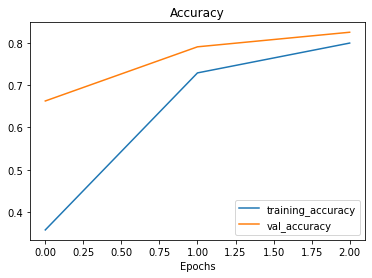

In [15]:
## lET'S CHECK OUR TRAINING CURVES
from Helper import plot_loss_curves
plot_loss_curves(history_0)

## Running a series of transfer learning experments-:

We have seen the transfer learning working incredibly with out 10% percent data. Now let's see how the model performs with the 1% of the dataset.

1. `Model_1` : Use feature extraction transfer learning with 1% of the training dataset with data augmentation.
2. `Model_2` :  Use feature extraction transfer learning with 10% of the training dataset with data augmentation.
3. `Model_3` : Use fine tuning transfer learning with 10% of the training data with data augmentation.
4. `Model_4` : Use fine tuning transfer learning with 10% of the training data with data augmentation.


We will use same datset in all the model experiments.

## getting and preprocessing the data for model 1

In [17]:
## Let's get the 1 percent data
from Helper import unzip_data
try:
  if os.path.exists(os.path.join(os.getcwd(),"10_food_classes_1_percent.zip")):
    print(f"data set is already unzipped and present")
  else:
    print("Downloading the data and unzipping it...")
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
    ### unzipping data
    print("Unzipping the data")
    unzip_data("10_food_classes_1_percent.zip")


    
except Exception as e:
  print("data not found in the directory... Hence downloading.....")
  

data set is already unzipped and present


In [18]:
## creating training and testing directories
train_dir_1_percent = "10_food_classes_1_percent/train" 
test_dir = "10_food_classes_1_percent/test"

In [19]:
## walkthrough the directory
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [26]:
## Setting up the dataloaders

IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE,
                                                                                 batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                      label_mode = "categorical",
                                                                      image_size = IMG_SIZE,
                                                                      batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [25]:
BATCH_SIZE

32